In [14]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt



In [15]:
# Suppress TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

# Hyperparameters
BATCH_SIZE    = 64
INPUT_SIZE    = 224         # 224×224 for EfficientNetB0 :contentReference[oaicite:4]{index=4}
NUM_CLASSES   = 100
LR_HEAD       = 1e-3
LR_FINE       = 1e-5
EPOCHS_HEAD   = 50
EPOCHS_FINE   = 50
L2_LAMBDA     = 2e-4


In [16]:
# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()

# Preprocessing: resize only (no manual normalization)
def preprocess(image, label):
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
                   .shuffle(50000) \
                   .batch(BATCH_SIZE)


In [17]:

# Data augmentation after resizing
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
                        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
                        .batch(BATCH_SIZE) \
                        .prefetch(tf.data.AUTOTUNE)


In [18]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Build model with EfficientNetB0 backbone (includes Rescaling layer) :contentReference[oaicite:5]{index=5}
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(INPUT_SIZE, INPUT_SIZE, 3)
)
base_model.trainable = False  # Phase 1

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


In [19]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR_HEAD),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [20]:
# Phase 1: Train only the head
history_head = model.fit(
    train_ds,
    epochs=EPOCHS_HEAD,
    validation_data=test_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 110s 109ms/step - accuracy: 0.3282 - loss: 3.3125 - val_accuracy: 0.6547 - val_loss: 1.5428 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.4992 - loss: 2.2641 - val_accuracy: 0.6667 - val_loss: 1.5298 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5280 - loss: 2.1590 - val_accuracy: 0.6775 - val_loss: 1.5277 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5382 - loss: 2.1226 - val_accuracy: 0.6923 - val_loss: 1.5338 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5511 - loss: 2.1120 - val_accuracy: 0.6901 - val_loss: 1.5378 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5581 - loss: 2.0804 - val_accuracy: 0.6918 - val_loss: 1.5406 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5573 -

In [22]:
# Phase 2: Unfreeze last 50 layers (except BatchNorm) for fine-tuning :contentReference[oaicite:6]{index=6}
for layer in base_model.layers[-50:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=LR_FINE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    epochs=EPOCHS_FINE,
    validation_data=test_ds,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 114ms/step - accuracy: 0.6693 - loss: 1.3839 - val_accuracy: 0.7557 - val_loss: 1.0668 - learning_rate: 1.0000e-05
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6866 - loss: 1.3039 - val_accuracy: 0.7597 - val_loss: 1.0442 - learning_rate: 1.0000e-05
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6993 - loss: 1.2771 - val_accuracy: 0.7622 - val_loss: 1.0284 - learning_rate: 1.0000e-05
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.7050 - loss: 1.2417 - val_accuracy: 0.7652 - val_loss: 1.0150 - learning_rate: 1.0000e-05
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 88ms/step - accuracy: 0.7145 - loss: 1.2144 - val_accuracy: 0.7679 - val_loss: 1.0046 - learning_rate: 1.0000e-05
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.7150 - loss: 1.2029 - val_accuracy: 0.7714 - val_loss: 0.9961 - learning_rate: 1.0000e-05
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/s

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8089 - loss: 0.8524
Test Loss: 0.8400 | Test Accuracy: 81.00%


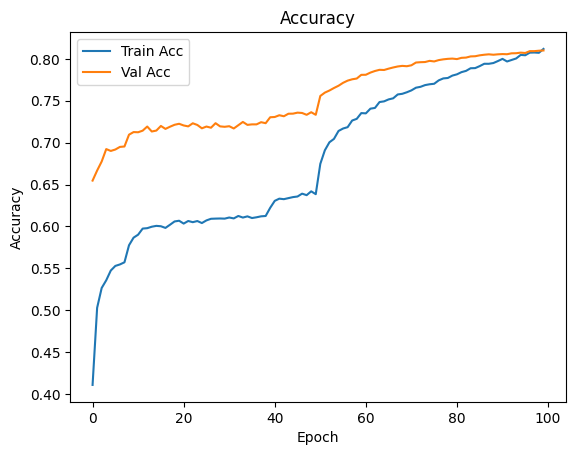

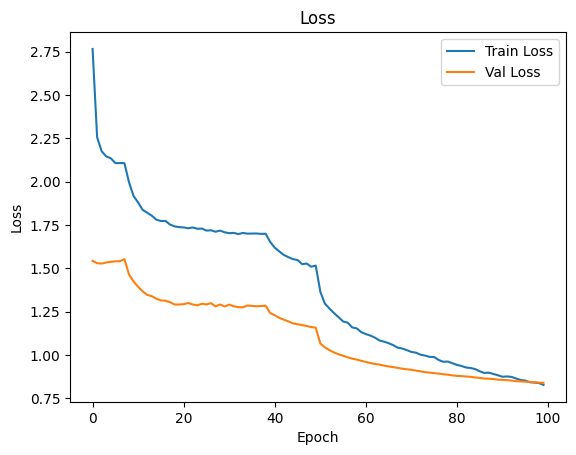

In [23]:

# Evaluate final performance
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {accuracy*100:.2f}%")

# Plot training history
plt.figure()
plt.plot(history_head.history['accuracy']  + history_fine.history['accuracy'],  label='Train Acc')
plt.plot(history_head.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy'); plt.show()

plt.figure()
plt.plot(history_head.history['loss']      + history_fine.history['loss'],      label='Train Loss')
plt.plot(history_head.history['val_loss']  + history_fine.history['val_loss'],  label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss'); plt.show()


In [24]:
!pip install scikit-learn seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


Generating predictions for test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step

Classification Report:
               precision    recall  f1-score   support

        apple     0.8879    0.9500    0.9179       100
aquarium_fish     0.8246    0.9400    0.8785       100
         baby     0.7396    0.7100    0.7245       100
         bear     0.7558    0.6500    0.6989       100
       beaver     0.5948    0.6900    0.6389       100
          bed     0.7890    0.8600    0.8230       100
          bee     0.8641    0.8900    0.8768       100
       beetle     0.8636    0.7600    0.8085       100
      bicycle     0.9579    0.9100    0.9333       100
       bottle     0.9118    0.9300    0.9208       100
         bowl     0.7391    0.6800    0.7083       100
          boy     0.6190    0.5200    0.5652       100
       bridge     0.9263    0.8800    0.9026       100
          bus     0.9155    0.6500    0.7602       100
    butterfly     0.8901    0.8100    0.8482       100
        came

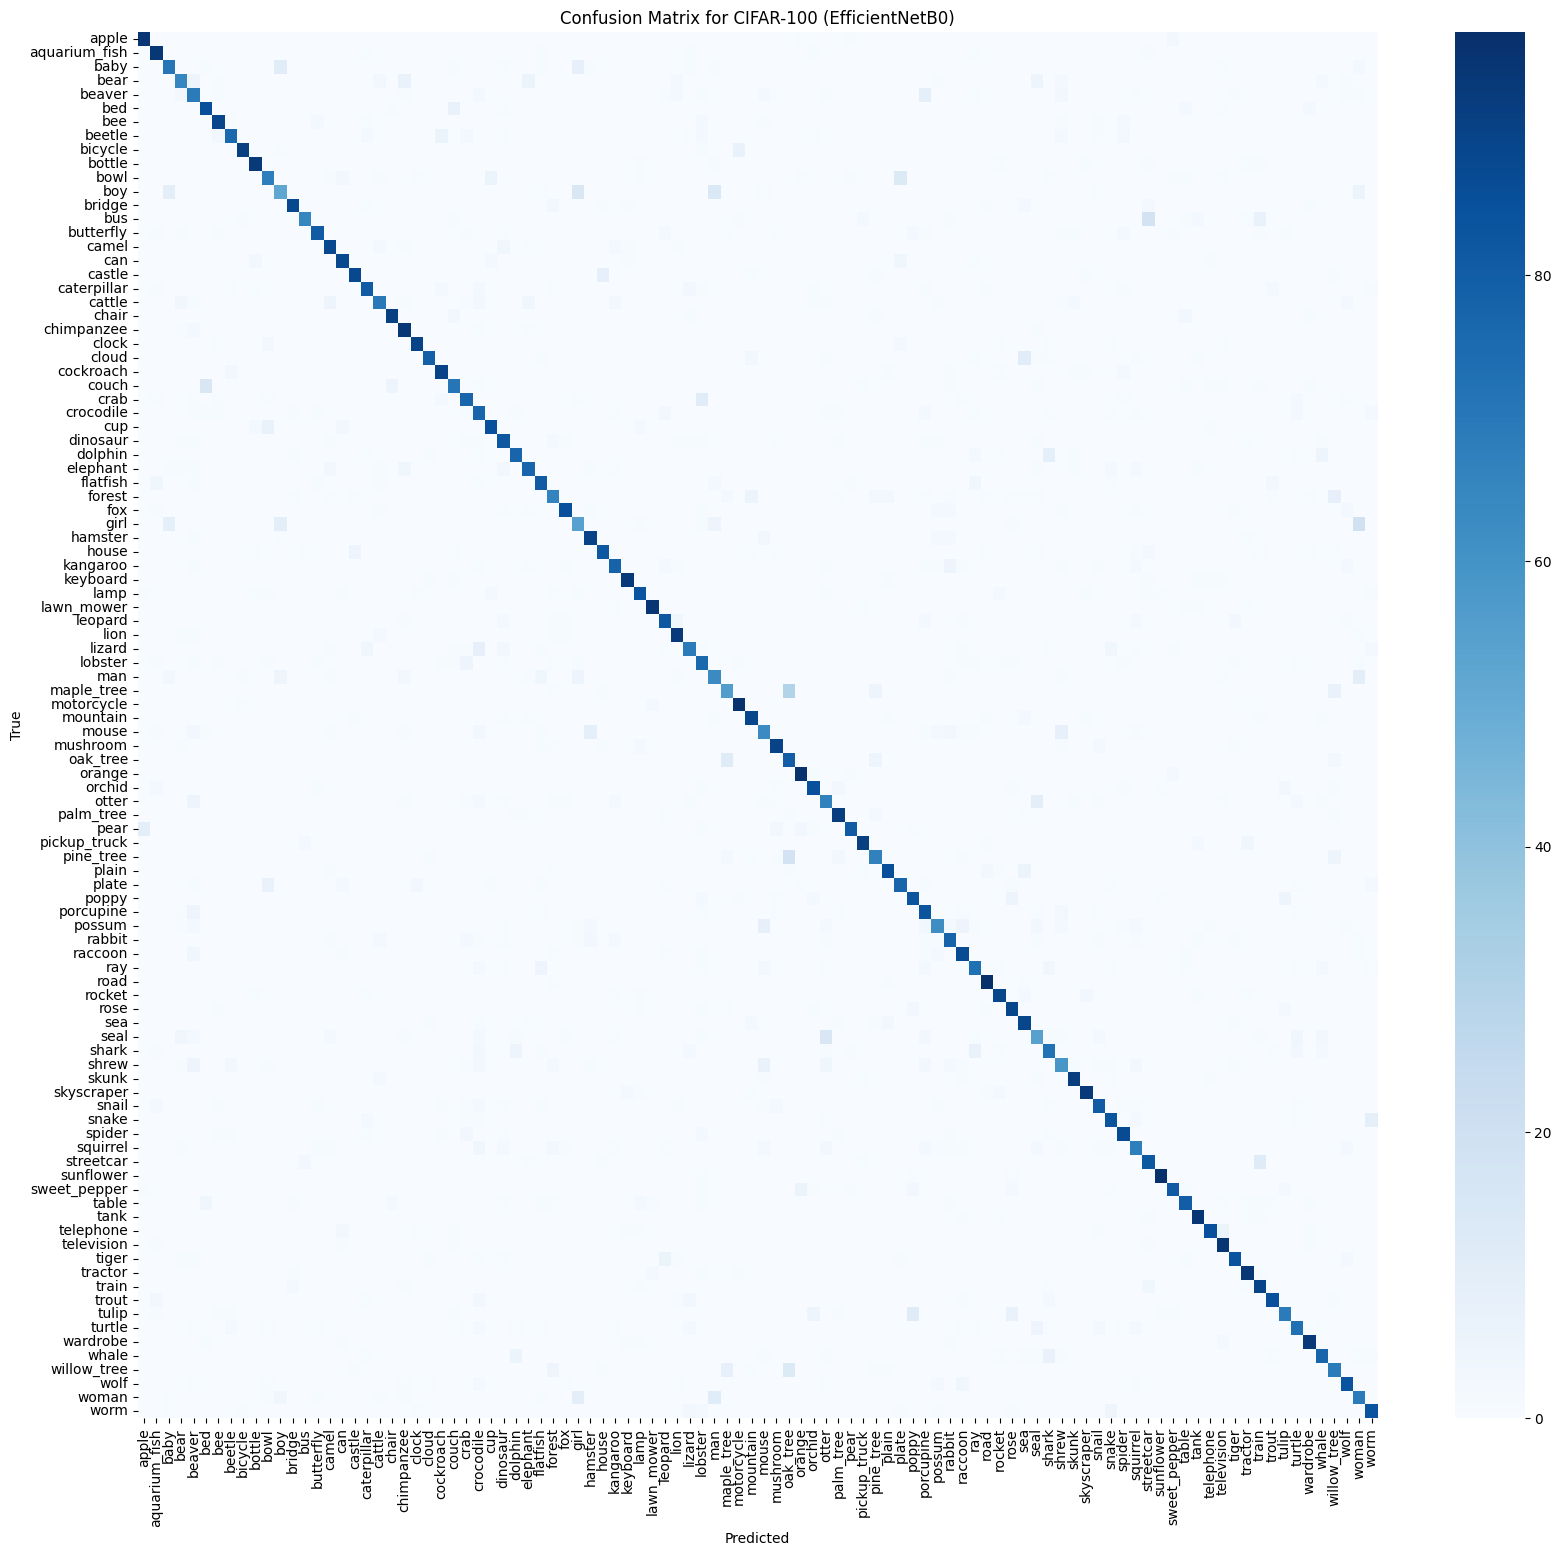

In [25]:
# Generate predictions for classification report and confusion matrix
print("\nGenerating predictions for test set...")
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = y_test.flatten()  # Flatten to match y_pred shape

# Load CIFAR-100 class names (fine labels)
# CIFAR-100 fine label names are available online or can be hardcoded
# For simplicity, we’ll use indices (0–99) as labels; replace with actual names if needed
#class_names = [str(i) for i in range(100)]  # Placeholder: replace with actual CIFAR-100 fine labels if available

# Optional: Load actual CIFAR-100 fine label names (manually defined or from external source)
# Example (subset for brevity):
# CIFAR-100 fine label names (full list)
cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Use actual class names if available, otherwise fallback to indices
#class_names = cifar100_fine_labels if len(cifar100_fine_labels) == 100 else class_names

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=cifar100_fine_labels, digits=4))

# Compute and visualize confusion matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(20, 18))  # Large size due to 100 classes
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=cifar100_fine_labels, yticklabels=cifar100_fine_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-100 (EfficientNetB0)')
plt.show()